<a href="https://colab.research.google.com/github/balvantchauhan/Image-Segmentation/blob/main/Image_Segmentation_using_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Segmentation using Transfer Learning

In this Problem, We focuses on the task of image segmentation, using a modified U-Net

What is image segmentation?
In an image classification task the network assign a label(or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case we will want to assign a class to each pixel of the image. This task as known as segmentation. A segmentation model returns much more detail information about the image. Image segmentation has many application in medical imaging, self-driving cars and satellite imaging to name a few.

In this segmentation problem we use the Oxford-IIIT Pet Dataset, The dataset consist of images of 37 pet breeds, with 200 images pre breed. Each images includes the corresponding labels, and pixel-wise masks. The mask are class-labels for each pixel.

Each pixel is given one of three categories.

Class 1 : Pixel belonging to pet.
Class 2 : Pixel bordering the pet
Class 3 : None of the above / Surrounding pixel.
Importing libraries

Each pixel is given one of three categories.

__Class 1__ : Pixel belonging to pet.

__Class 2__ : Pixel bordering the pet.  

__Class 3__ : None of the above / Surrounding pixel. 


### Importing Required Libraries

In [122]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, ReLU, Input, Concatenate
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Other Params

In [15]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
BUFFER_SIZE = 1000

### Download the Oxford-IIIT Pets dataset

The dataset is available from TensorFlow Datasets. The segmentation masks are included in version 3+.

In [16]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZ8C7SZ/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZ8C7SZ/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In addition, the image color values are normalized to the `[0,1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either `{1, 2, 3}`. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : `{0, 1, 2}`.

In [17]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [18]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], IMG_SIZE)
  input_mask = tf.image.resize(datapoint['segmentation_mask'], IMG_SIZE)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

The dataset already contains the required splits of test and train and so continue to use the same split.

In [19]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [20]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation of randoly-flipping an image

In [21]:
class Augment(Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they will make the same random changes.
    self.augment_inputs = RandomFlip(mode='horizontal', seed=seed)
    self.augment_labels = RandomFlip(mode='horizontal', seed=seed)

  def call(self, input, labels):
    inputs = self.augment_inputs(input)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

In [22]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Take a look at an image example and it's correponding mask from the dataset.

In [23]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

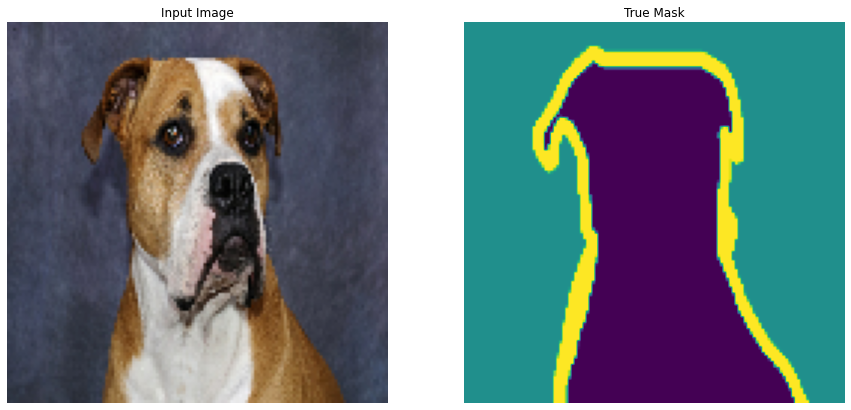

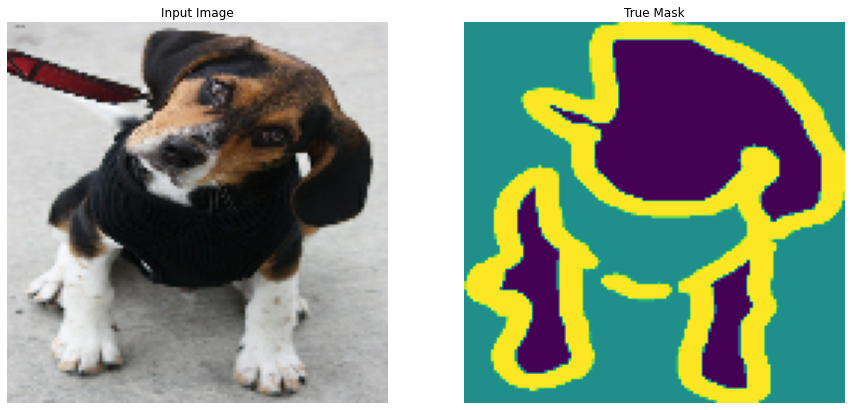

In [24]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### Define the model


The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - MobileNetV2 - as the encoder.



As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.




In [44]:
INPUT_SHAPE = IMG_SIZE + (3, )
base_model = MobileNetV2(input_shape=INPUT_SHAPE)

# Use activation of these layers

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_output = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder_stack = Model(inputs=base_model.input, outputs=base_model_output)
encoder_stack.trainable = False

print(len(encoder_stack.layers))


150


The decoder/upsampler is simply a series of upsample blocks

In [26]:
def decoder(filters, size, norm_type='batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
  if norm_type.lower() == 'batchnorm':
    result.add(BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())
  if apply_dropout:
    result.add(Dropout(0.5))
  result.add(ReLU())
  return result

In [119]:
decoder_stack = [
    decoder(512, 3),  # 4x4 -> 8x8
    decoder(256, 3),  # 8x8 -> 16x16
    decoder(128, 3),  # 16x16 -> 32x32
    decoder(64, 3),   # 32x32 -> 64x64
]

In [124]:
def unet_model():
  inputs = Input(shape= INPUT_SHAPE)
  # Downsampling trhough the model
  skips = encoder_stack(inputs)
  x = skips[-1] 
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(decoder_stack, skips):
    x = up(x)
    concat = Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model

  last = Conv2DTranspose(3, 3, strides=2 ,padding='same',)
  x = last(x)
  return Model(inputs=inputs, outputs=x)

Note that on the number of filters on the last layer is set to the number of output_channels. This will be one output channel per class.



### Train the model

Now, all that is let to do is to compile and train the model.
Since this is a multiclass classification problem a `CetegoricalCrossentropy with from_logits=true` is the standard loss function.
Use losses.SparseCategoricalCrossentropy(from_logits=True) since the labels are scalar integers instead of vectors of scores for scores for each class for each pixel.

In [125]:
model = unet_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Have a quick look at the resulting model architecture

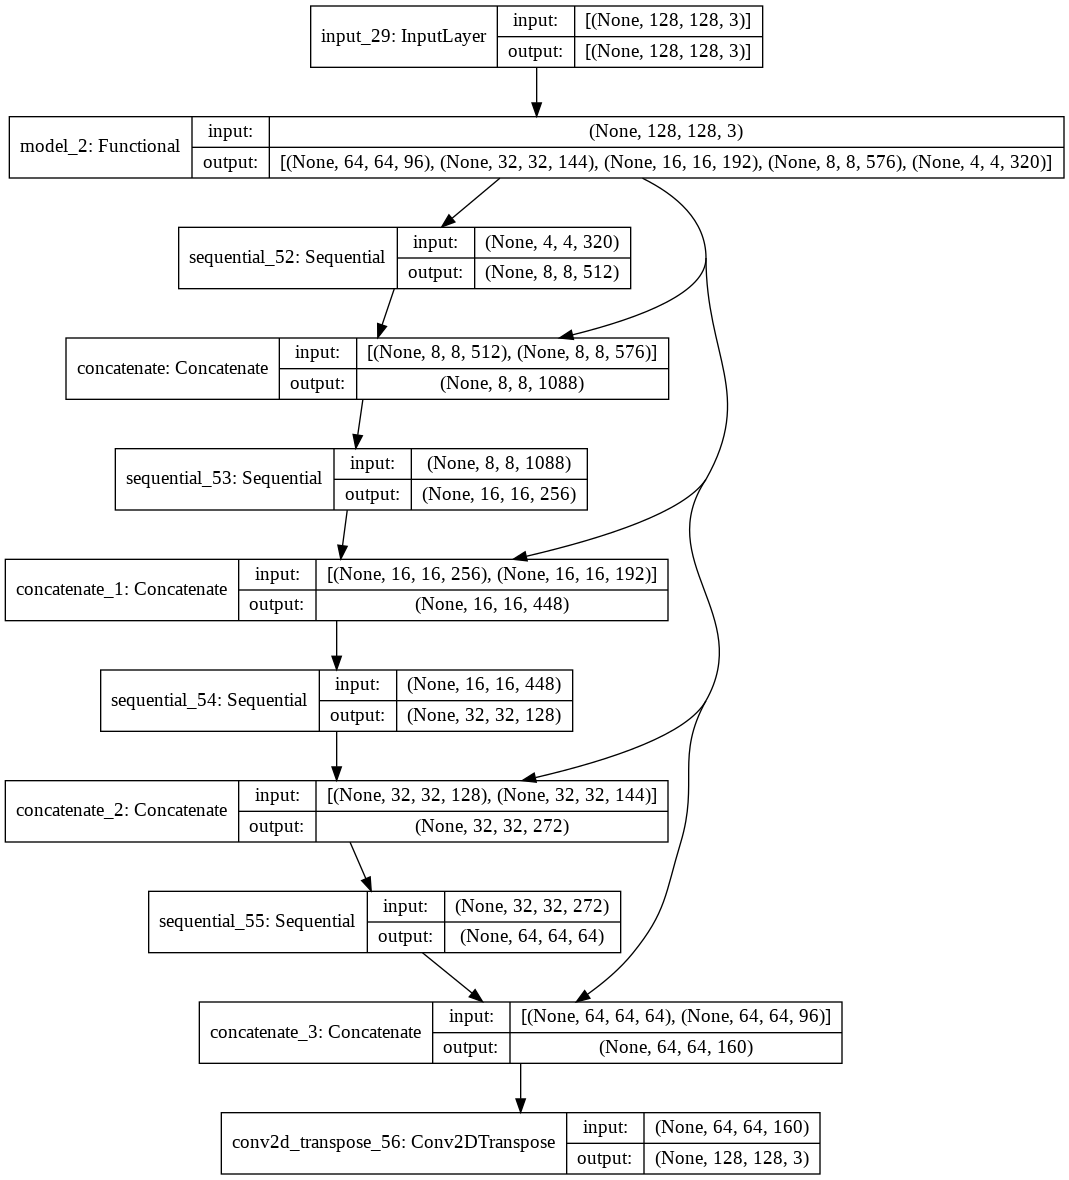

In [126]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to see what it predicts before training.

In [127]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [128]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

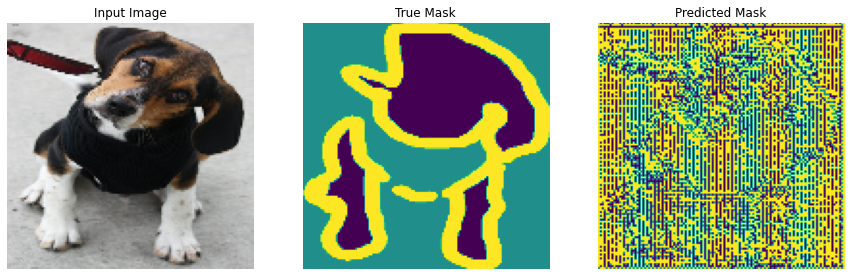

In [129]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training.




In [130]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

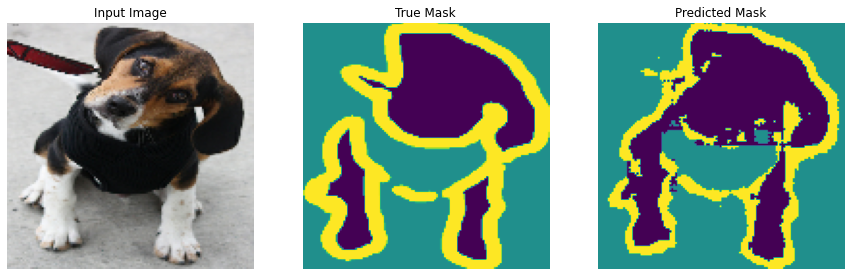


Sample Prediction after epoch 20



In [131]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

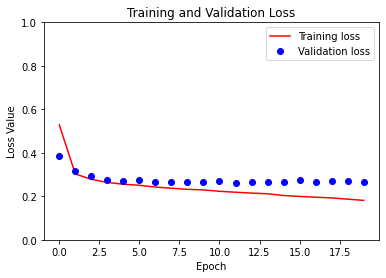

In [132]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Make predictions

Now make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

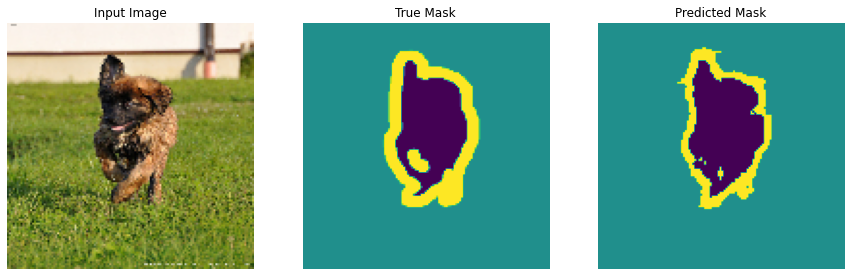

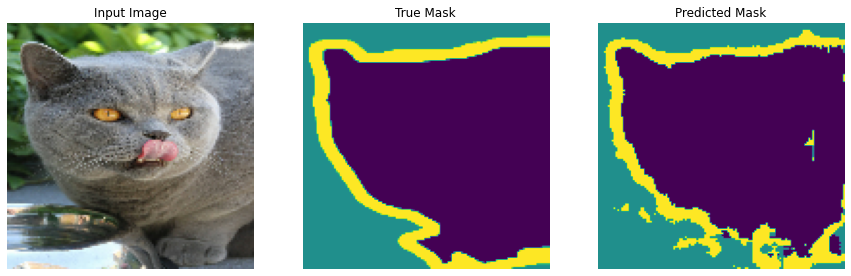

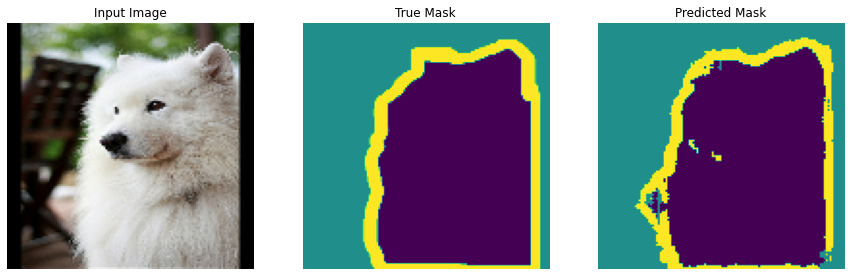

In [133]:
show_predictions(test_batches, 3)